# Group Assignment 3: Part 1

### Team: Olivia Arena, Deja McCauley, Lindsey Morris, Cassie Truong


### Team Update

To account for the reduced group size and a need to merge our broad variables of interest into a cohesive narrative, our group revised our research question. A copy of the revised research question, as well as some basic definitions and context are provided below.

### Revised Research Question: 
#### In terms of social infrastructure and the built environment, what community needs emerge as a priority for 

#### North Philadelphia’s Logan neighborhood that could be addressed through the redevelopment of the Logan
#### Triangle?

Social infrastructure is defined as the policies, resources, and services that ensure people can participate in productive social and economic activities. This includes social services, public education, corrections and justice, public transportation, and healthcare. The built environment includes all of the physical parts of where we live and work (e.g., homes, buildings, streets, and open spaces).

The existing social infrastructure and built environment of a neighborhood play a key role in what services and resources are accessible to residents and how far one may need to travel to access what they ultimately need to survive and secure employement. For the Logan neighborhood, our group wants to examine the gaps of accessiblity to essential services and public resources based on the existing social infrastructure and built environment. 

#### Notebook Description:

In this notebook, an isochrone map is created to provide a five, ten, and fifteen minute walk-shed from Logan Triangle. The walkshed will be used as a reference map when reviewing variables explored in Parts 1-4. The four parts will explore gaps in the social infrastructure and built environment that surrounds Logan Triangle. 

### Importing libraries that will be used to create an isochrome map.

In [1]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox
import contextily as ctx
import folium

### Fetching Network Data from OpenStreet Maps

For this project, we are creating a walkshed from Wyoming and 9th, which is at the center of the Logan Triangle. The lat/lon of this center point is 40.02359284993457, -75.13947869444846.

In [2]:
# Set the place (latitude & longitude coordinates), network type, trip times, and travel speed
# latlon = [40.02359284993457, -75.13947869444846]
latlon = [40.02359284993457, -75.13947869444846]
network_type = 'walk'
trip_times = [5, 10, 15]
meters_per_minute = 75 # travel distance per minute

In [3]:
# download the street network
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000)

In [4]:
# project our network data to Web Mercator (measurements are in meters)
G = ox.project_graph(G, to_crs='epsg:3857')

In [5]:
# convert nodes and edges to geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [6]:
gdf_edges['highway'].value_counts()

residential                    5106
service                        4348
footway                        3806
tertiary                       1312
primary                         564
secondary                       512
trunk                           278
path                             48
[footway, steps]                 38
unclassified                     30
steps                            22
tertiary_link                    20
[residential, service]           18
trunk_link                       16
secondary_link                   10
pedestrian                        8
primary_link                      4
[path, footway]                   4
[path, residential]               2
[residential, footway]            2
[unclassified, residential]       2
Name: highway, dtype: int64

The output above shows that the most common road type surrounding the Logan Triagle is residential. Below a land use map will provide additional context to what else encompasses the built environment.

### Retrieve the centroid and nearest node to the lat/lon point

In [7]:
# get the bounding box coordinates
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-8367102.801069509
4866757.586505422
-8361874.135718898
4871986.267358854


In [8]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-8364488.468394203
4869371.926932138


In [9]:
# use osmnx's distance.nearest_nodes command to get the id for the nearest node
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)
print('The id for the nearest node is ' + str(center_node))

The id for the nearest node is 110344907


In [10]:
# what is this record?
gdf_nodes.loc[[center_node]]

y             x  street_count        lon        lat  \
osmid                                                                       
110344907  4.869352e+06 -8.364476e+06             4 -75.139367  40.023459   

                   highway                          geometry  
osmid                                                         
110344907  traffic_signals  POINT (-8364476.073 4869351.863)

### Map the OSM Network Layers

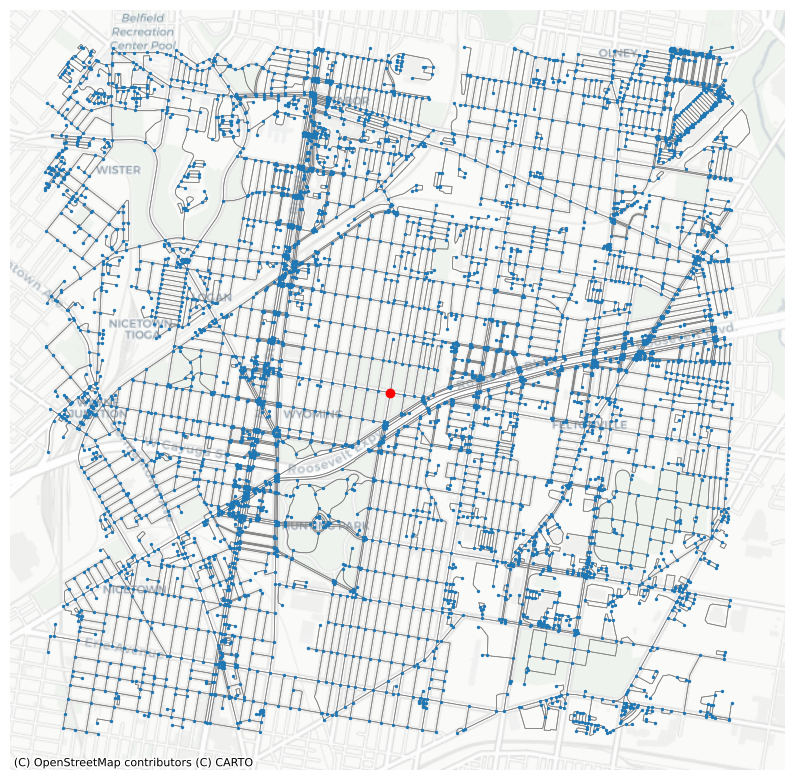

In [11]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

The output above visualizes where the lat/lon point lands on a map by displaying as red dot, while the edges and nodes appear in blue on a greyscale basemap. Now that we have mapped the network data, we can add our walkshed. 

#### Produce the Isochrones

First let's take a look at a sample of the dataset

In [12]:
# a quick look at the data
gdf_edges[['osmid','name','highway','length']].sample(5)

osmid                   name      highway  \
u          v          key                                                   
110351479  4459866406 0      62263813               C Street  residential   
5541241622 5541241624 0     626353150     North Front Street     tertiary   
110217830  9608084417 0    1009933214      West Olney Avenue     tertiary   
110250252  110250243  0     195665272   West Rockland Street  residential   
110265170  110265160  0      12162545  West Duncannon Avenue  residential   

                           length  
u          v          key          
110351479  4459866406 0    41.200  
5541241622 5541241624 0    11.361  
110217830  9608084417 0    67.346  
110250252  110250243  0    67.791  
110265170  110265160  0    71.326

Before creating an isochrone map, a cost (or average walk time) must be attributed to each network edge.

In [13]:
# create a new column, calculate the time it takes to travel that edge
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

Now let's check a data sample, to make sure the walk_time column was added.

In [14]:
gdf_edges[['osmid','name','highway','length','walk_time']].sample(10)

osmid  \
u          v           key                                     
109727980  110297830   0                            12166684   
6900656731 10029056754 0                           737082142   
4054043114 109907835   0                           386200599   
109726961  110211923   0                            43226676   
5543960580 5543960581  0                           578664069   
4054043116 4054043117  0                           403012485   
110202776  110202748   0    [12156098, 133976194, 133976191]   
8949729014 5543893932  0                           578655399   
5543894303 5543894273  0                           578655523   
5854035509 5541240860  0                           578238033   

                                          name      highway   length  \
u          v           key                                             
109727980  110297830   0    North Camac Street  residential  158.135   
6900656731 10029056754 0                   NaN      footway   27.727   
4054043114 109907835   0    North Front Street  residential   58.996   
109726961  110211923   0       Clarissa Street    secondary   51.828   
5543960580 5543960581  0                   NaN      service   37.618   
4054043116 4054043117  0                   NaN      service   41.308   
110202776  110202748   0     East Olney Avenue     tertiary  333.901   
8949729014 5543893932  0                   NaN      service   61.406   
5543894303 5543894273  0                   NaN      service   25.082   
5854035509 5541240860  0                   NaN      service   46.275   

                            walk_time  
u          v           key             
109727980  110297830   0     2.108467  
6900656731 10029056754 0     0.369693  
4054043114 109907835   0     0.786613  
109726961  110211923   0     0.691040  
5543960580 5543960581  0     0.501573  
4054043116 4054043117  0     0.550773  
110202776  110202748   0     4.452013  
8949729014 5543893932  0     0.818747  
5543894303 5543894273  0     0.334427  
5854035509 5541240860  0     0.617000

Looks Good!

#### Customize the Isochrone

Apply our chosen group colopmap ('GnBu') to the map

In [15]:
# choose a colormap
cmap = 'GnBu'

In [16]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15]
['#f7fcf0', '#7accc4', '#084081']


Now, create a time_color function to apply each walkshed time to a color from the chosen color map

In [17]:
# create a list of "zipped" time/colors
time_color = list(zip(trip_times, iso_colors))
time_color

[(5, '#f7fcf0'), (10, '#7accc4'), (15, '#084081')]

Then, loop the the list of time/colors

In [18]:
# loop through the list of time/colors
for time,color in list(time_color):
    print('The color for '+str(time)+' minutes is ' + color)

The color for 5 minutes is #f7fcf0
The color for 10 minutes is #7accc4
The color for 15 minutes is #084081


Because the Isochrone nodes need to be drawn from the outside -> in, we must reverse the aboce time/color order.

In [19]:
# reverse the order so that outside nodes get associated first
time_color.reverse()
# time_color.sort(reverse=True)
time_color

[(15, '#084081'), (10, '#7accc4'), (5, '#f7fcf0')]

In [20]:
# loop through each trip time and associated color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time,distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ' + color)
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 949 nodes within 15 minutes #084081
There are 308 nodes within 10 minutes #7accc4
There are 74 nodes within 5 minutes #f7fcf0


In [21]:
# spot check
gdf_nodes.sample(10)

y             x  street_count        lon        lat  \
osmid                                                                        
109871106   4.870891e+06 -8.362064e+06             3 -75.117703  40.034047   
6356923275  4.871737e+06 -8.365069e+06             4 -75.144697  40.039867   
109756739   4.871927e+06 -8.362117e+06             3 -75.118176  40.041172   
5541241388  4.869408e+06 -8.363394e+06             3 -75.129645  40.023846   
110423663   4.867537e+06 -8.366664e+06             3 -75.159024  40.010976   
5541242019  4.868593e+06 -8.363173e+06             1 -75.127658  40.018236   
109922299   4.871099e+06 -8.365349e+06             3 -75.147209  40.035476   
6324562580  4.868117e+06 -8.365339e+06             4 -75.147122  40.014964   
5543962112  4.869408e+06 -8.365036e+06             1 -75.144398  40.023846   
109887076   4.870433e+06 -8.365267e+06             3 -75.146471  40.030895   

             highway                          geometry  time    color  
osmid                                                                  
109871106        NaN  POINT (-8362064.459 4870891.073)   NaN      NaN  
6356923275  crossing  POINT (-8365069.417 4871737.278)   NaN      NaN  
109756739        NaN  POINT (-8362117.057 4871927.116)   NaN      NaN  
5541241388       NaN  POINT (-8363393.825 4869408.179)  15.0  #084081  
110423663        NaN  POINT (-8366664.269 4867537.352)   NaN      NaN  
5541242019       NaN  POINT (-8363172.633 4868592.625)   NaN      NaN  
109922299        NaN  POINT (-8365349.063 4871098.939)   NaN      NaN  
6324562580  crossing  POINT (-8365339.333 4868117.060)   NaN      NaN  
5543962112       NaN  POINT (-8365036.077 4869408.048)  10.0  #7accc4  
109887076        NaN  POINT (-8365266.898 4870432.800)   NaN      NaN

NaN are not within 15 minutes. Instead of deleting the null values, we will apply a neutral gray.

In [22]:
# the NaN values then need to be populated with a valid color
gdf_nodes['color'].fillna('#cccccc', inplace=True)

The color that will fill the null fields are grey. 

In [23]:
# another spot check: are all values in the color column populated?
gdf_nodes.sample(10)

y             x  street_count        lon        lat  \
osmid                                                                        
4781793701  4.868407e+06 -8.365623e+06             4 -75.149674  40.016956   
6900636965  4.871941e+06 -8.362209e+06             3 -75.119000  40.041270   
6309654041  4.868630e+06 -8.363123e+06             4 -75.127209  40.018492   
6309653928  4.868037e+06 -8.363563e+06             4 -75.131161  40.014413   
6356860687  4.870234e+06 -8.365282e+06             3 -75.146608  40.029526   
5547248299  4.867048e+06 -8.362006e+06             3 -75.117182  40.007609   
4459866017  4.869600e+06 -8.362939e+06             4 -75.125555  40.025168   
6348444702  4.869947e+06 -8.365348e+06             4 -75.147202  40.027553   
4459866025  4.869606e+06 -8.363234e+06             3 -75.128211  40.025209   
5541242287  4.868310e+06 -8.363284e+06             3 -75.128654  40.016289   

             highway                          geometry  time    color  
osmid                                                                  
4781793701  crossing  POINT (-8365623.476 4868406.556)   NaN  #cccccc  
6900636965       NaN  POINT (-8362208.851 4871941.293)   NaN  #cccccc  
6309654041  crossing  POINT (-8363122.673 4868629.807)   NaN  #cccccc  
6309653928  crossing  POINT (-8363562.563 4868037.017)   NaN  #cccccc  
6356860687       NaN  POINT (-8365282.160 4870233.860)   NaN  #cccccc  
5547248299       NaN  POINT (-8362006.406 4867048.104)   NaN  #cccccc  
4459866017  crossing  POINT (-8362938.550 4869600.299)  15.0  #084081  
6348444702  crossing  POINT (-8365348.239 4869947.073)  15.0  #084081  
4459866025       NaN  POINT (-8363234.182 4869606.274)  15.0  #084081  
5541242287       NaN  POINT (-8363283.552 4868309.708)   NaN  #cccccc

<AxesSubplot: >

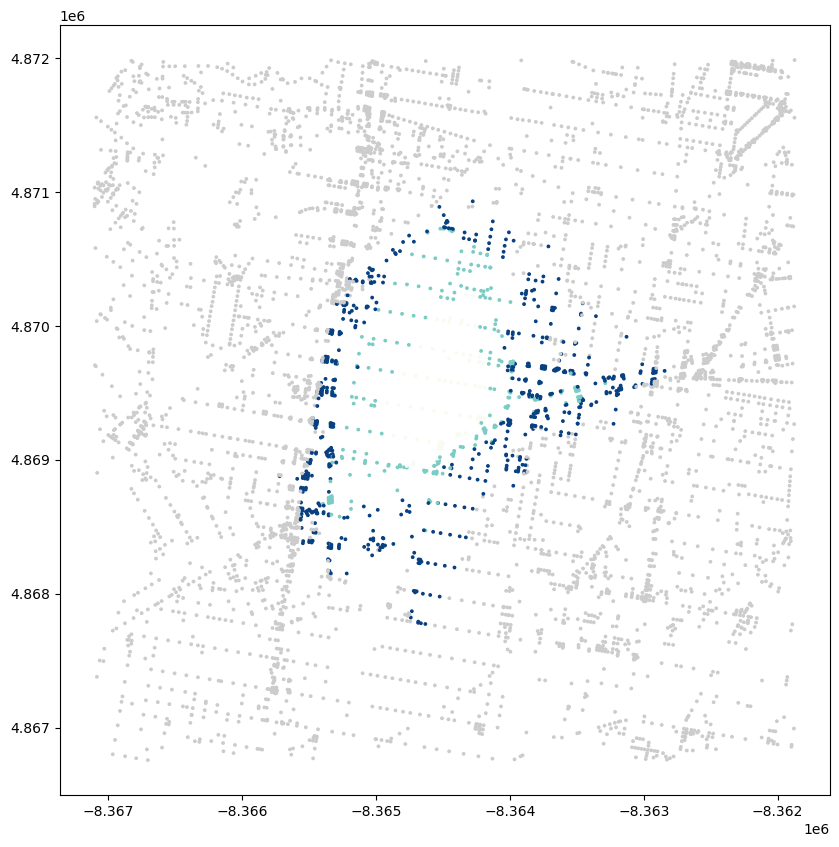

In [24]:
# map it
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3,
               )

#### Draw Polygons for Each Time Area

In [25]:
# put the 10 minute nodes in a variable
gdf_10 = gdf_nodes[gdf_nodes['time']==10]

<AxesSubplot: >

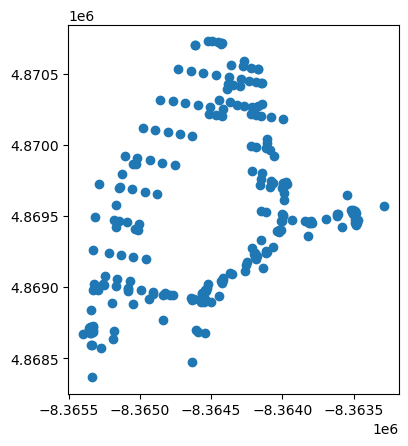

In [26]:
gdf_10.plot()

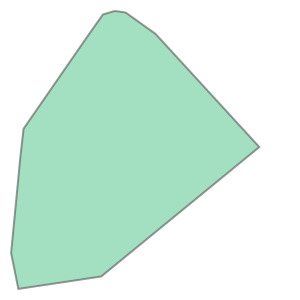

In [27]:
# combine all the points (unary_union) and create a convex hull polygon
gdf_10.unary_union.convex_hull

In [28]:
# dissolve the nodes by time
# adding the "time" argument creates a separate geometry (multipoint in this case) for each unique time category
isochrones = gdf_nodes.dissolve(by = "time")
isochrones

geometry             y  \
time                                                                    
5.0   MULTIPOINT (-8364918.568 4869426.146, -8364869...  4.870000e+06   
10.0  MULTIPOINT (-8365396.908 4868672.251, -8365356...  4.869728e+06   
15.0  MULTIPOINT (-8365720.836 4868878.472, -8365589...  4.869873e+06   

                 x  street_count        lon        lat          highway  \
time                                                                      
5.0  -8.364260e+06             4 -75.137422  40.027918  traffic_signals   
10.0 -8.363969e+06             4 -75.134811  40.026046             stop   
15.0 -8.363505e+06             4 -75.130642  40.027043         crossing   

        color  
time           
5.0   #f7fcf0  
10.0  #7accc4  
15.0  #084081

In [29]:
# for each row, create a convex hull
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones

time                                           geometry
0   5.0  POLYGON ((-8364771.292 4868954.786, -8364816.9...
1  10.0  POLYGON ((-8365335.370 4868367.049, -8365396.9...
2  15.0  POLYGON ((-8364632.098 4867774.347, -8364665.4...

In [30]:
# reverse the order so that outer polygon gets drawn first
isochrones.sort_values(by='time', ascending=False,inplace=True)
isochrones

time                                           geometry
2  15.0  POLYGON ((-8364632.098 4867774.347, -8364665.4...
1  10.0  POLYGON ((-8365335.370 4868367.049, -8365396.9...
0   5.0  POLYGON ((-8364771.292 4868954.786, -8364816.9...

In [31]:
# reverse the colors too!
iso_colors.reverse()
iso_colors

['#084081', '#7accc4', '#f7fcf0']

<AxesSubplot: >

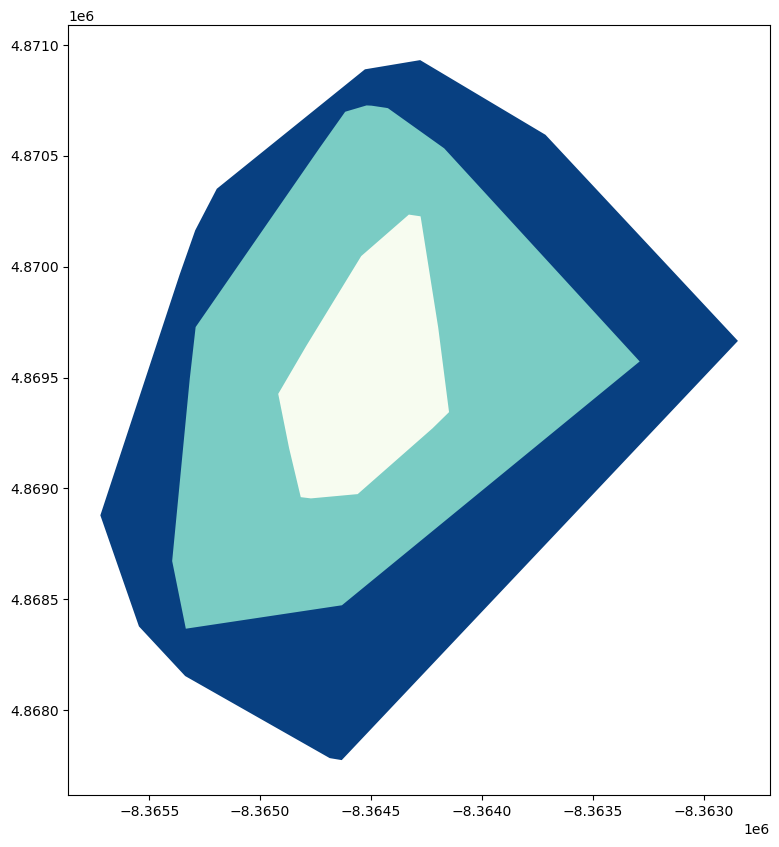

In [32]:
isochrones.plot(figsize=(10,10),alpha=1,color=iso_colors, legend=True)

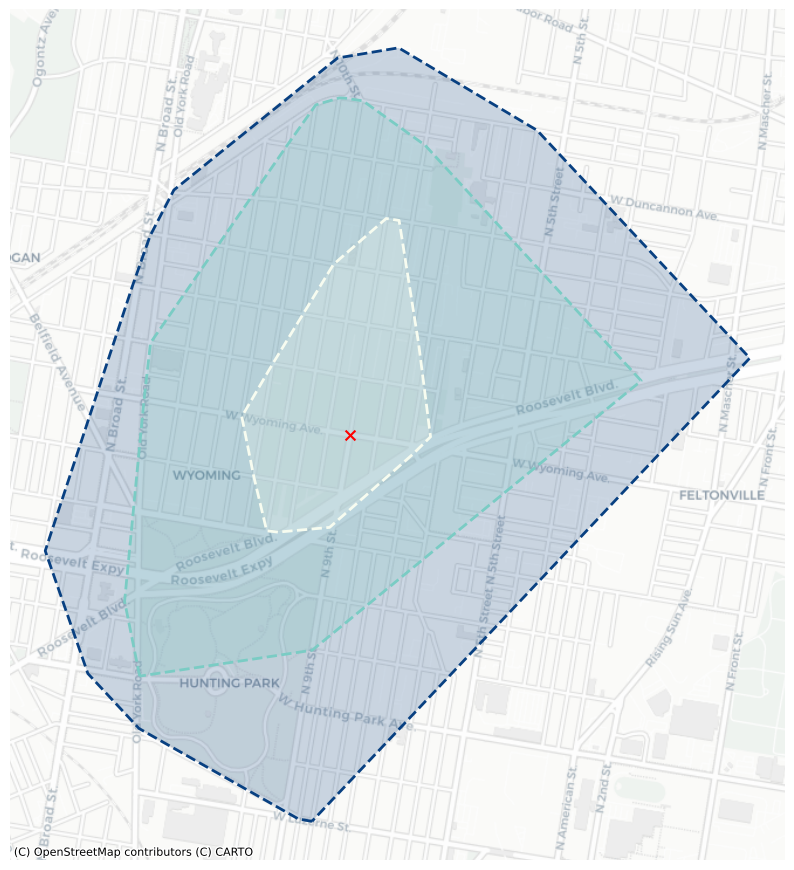

In [33]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=iso_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True, # even though it is numeric, treat it as categorical
    color=iso_colors,
    )

# add the center node in red
gdf_nodes.loc[[center_node]].plot(ax=ax,color='r',marker='x',markersize=50)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [34]:
# to draw custom legend elements, import these libraries
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

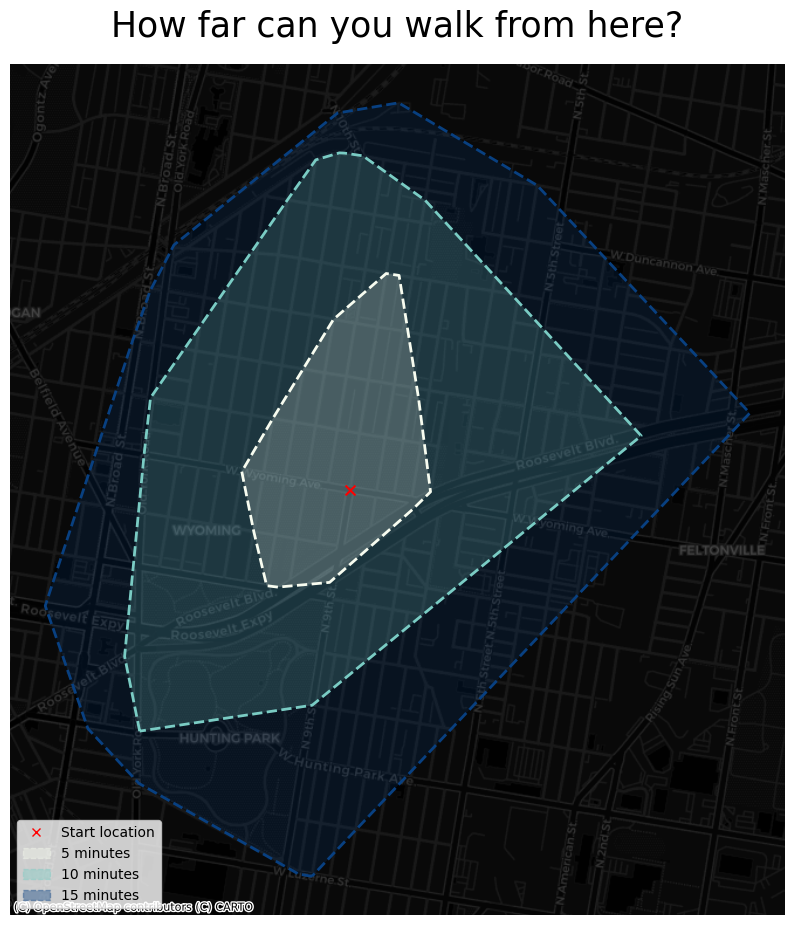

In [35]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=iso_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True, # even though it is numeric, treat it as categorical
    color=iso_colors,
    )

# add the center node in red
gdf_nodes.loc[[center_node]].plot(
    ax=ax,
    color='r',
    marker='x',
    markersize=50
    )

# build custom legend
legend_elements = [
    # add the center node to the legend
    Line2D([0], [0], marker='x', color='red', linestyle='',label='Start location', markersize=6),
    ]

# sort back to small time to large time
# time_color.sort(reverse=False)
time_color.reverse()

# loop through the list of time/colors and add each to the legend
for time,color in list(time_color):
    legend_item = Patch(facecolor=color, edgecolor=color, linestyle='--',linewidth=1,label=str(time)+' minutes',alpha=0.4)
    legend_elements.append(legend_item)

# add the legend
ax.legend(handles=legend_elements,loc='lower left') # location options: upper/center/lower and left/center/right

# add a title
ax.set_title('How far can you walk from here?',fontsize=25,pad=20)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)


In [36]:
m = folium.Map(location=latlon,zoom_start=15, tiles='Stamen Terrain')
# and here comes the wow factor...
isochrones.explore(m=m,column='time',cmap=cmap,categorical=True)
gdf_nodes.explore(m=m,column='time')

This interactive map provides viewers the ability to zoom in and out to view the map more closely and examine the walkability of specific intersections. 

The custom legend on the bottom right represents the amount of time by the walkshed polygons created, while the the bar at the top of the map represents the time by each node on the map. Unfortunately, this may be confusing for the viewer as they follow opposte color schemes. I'd like to explore removing the nodes below.

In [37]:
m = folium.Map(location=latlon,zoom_start=15, tiles='Stamen Terrain')
# and here comes the wow factor...
isochrones.explore(m=m,column='time',cmap=cmap,categorical=True)

I find this version to be much more digestible visually.

This isochrone map will be helpful to overlay onto our other spatial data sets such as neigbhorhood services, open space, affordable housing, etc. Overlaying this data can reveal gaps in the local walkshed ofsocial infrastructure and built environment that surrounds Logan Triangle. 

Now, let's move on to Part 2 to explore our updated housing data outputs!